## Model for Student Housing - Green College

In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# Load the dataset
df = pd.read_csv('../data/preprocessed/df_agg_area.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097 entries, 0 to 1096
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         1097 non-null   object
 1   vacancies    1097 non-null   int64 
 2   area_BROCK   1097 non-null   int64 
 3   area_EXCH    1097 non-null   int64 
 4   area_FRASER  1097 non-null   int64 
 5   area_GREEN   1097 non-null   int64 
 6   area_IONA    1097 non-null   int64 
 7   area_KWTQ    1097 non-null   int64 
 8   area_MARINE  1097 non-null   int64 
 9   area_POND    1097 non-null   int64 
 10  area_STJOHN  1097 non-null   int64 
 11  area_TBIRD   1097 non-null   int64 
 12  area_AP_UA   1097 non-null   int64 
dtypes: int64(12), object(1)
memory usage: 111.5+ KB


In [4]:
# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

In [5]:
# Rename column 'date' to Prophet's format
df.rename(columns={'date': 'ds'}, inplace=True)
df.head()

,ds,vacancies,area_BROCK,area_EXCH,area_FRASER,area_GREEN,area_IONA,area_KWTQ,area_MARINE,area_POND,area_STJOHN,area_TBIRD,area_AP_UA
0,2021-11-01,74,1,5,2,7,0,0,23,6,2,11,17
1,2021-11-02,91,2,5,2,7,0,0,25,7,5,12,26
2,2021-11-03,93,2,5,2,7,0,0,25,7,4,13,28
3,2021-11-04,95,2,5,2,7,0,0,26,7,5,13,28
4,2021-11-05,93,2,5,2,7,0,0,26,7,5,12,27


In [6]:
# Melt the dataframe to convert from wide to long format
df_long = df.melt(id_vars=['ds'], var_name='area', value_name='y')

# Preview the melted data
df_long.head()

,ds,area,y
0,2021-11-01,vacancies,74
1,2021-11-02,vacancies,91
2,2021-11-03,vacancies,93
3,2021-11-04,vacancies,95
4,2021-11-05,vacancies,93


In [7]:
# Display max vacancies per month 

# Define the area
area ='area_GREEN'

# Extract year and month to group by month
df['year_month'] = df['ds'].dt.to_period('M')

# Find the date with the maximum vacancies for each month
idx = df.groupby('year_month')[area].idxmax()

# Retrieve the rows with the maximum vacancies
max_vacancy_per_month = df.loc[idx, ['ds', 'year_month', area]].reset_index(drop=True)

# Rename columns for clarity
max_vacancy_per_month.rename(columns={'ds': 'Date', 'year_month': 'Month', area: 'Max Green Vacancies'}, inplace=True)

# Display the result
print(max_vacancy_per_month)

         Date    Month  Max Green Vacancies
0  2021-11-01  2021-11                    7
1  2021-12-02  2021-12                    7
2  2022-01-01  2022-01                    6
3  2022-02-01  2022-02                    6
4  2022-03-02  2022-03                    8
5  2022-04-22  2022-04                    9
6  2022-05-02  2022-05                   11
7  2022-06-02  2022-06                   11
8  2022-07-02  2022-07                   12
9  2022-08-25  2022-08                   38
10 2022-09-12  2022-09                    3
11 2022-10-01  2022-10                    2
12 2022-11-01  2022-11                    2
13 2022-12-05  2022-12                    4
14 2023-01-02  2023-01                    7
15 2023-02-07  2023-02                    8
16 2023-03-02  2023-03                   10
17 2023-04-02  2023-04                   11
18 2023-05-10  2023-05                   13
19 2023-06-01  2023-06                   14
20 2023-07-02  2023-07                   15
21 2023-08-25  2023-08          

### 1. Basic prediction

In [8]:
# Define holidays - Move out day for Green College contract is always Aug 25 each year
holidays = pd.DataFrame({
  'holiday': 'move_out',
  'ds': pd.to_datetime(['2022-08-25', '2023-08-25', '2024-08-25']),  # move-out dates
    'lower_window': [-1, -1, -1],
    'upper_window': [6, 6, 6]
})

In [ ]:
# Define the area for model
area = 'area_GREEN'

# Rename columns for Prophet
df_green = df[['ds', area]].rename(columns={area: 'y'})

# Create a new column that marks the last day of the month - it will be an additional regressor for model
df_green['end_of_month'] = df_green['ds'].dt.is_month_end.astype(int)

# Initialize the Prophet model with specified hyperparameters
# - 'holidays' provides holiday information to the model
# - 'yearly_seasonality=30' increases flexibility for capturing yearly trends
# - 'changepoint_prior_scale' controls sensitivity to changepoints
# - 'seasonality_mode' defines how seasonal effects are modeled (here additive)
model = Prophet(holidays=holidays, 
                yearly_seasonality=30,
                changepoint_prior_scale=0.05,
                seasonality_prior_scale=15,
                seasonality_mode='additive')

# Add 'end_of_month' as a regressor
model.add_regressor('end_of_month')

# Fit the model
model.fit(df_green)

# Predict on future (1 year in the future)
future = model.make_future_dataframe(periods=365)

# Add the 'end_of_month' column to the future dataframe
future['end_of_month'] = future['ds'].dt.is_month_end.astype(int)

# Generate predictions for the future
forecast = model.predict(future)

# Clip the predicted values to ensure no negative values
forecast['yhat'] = forecast['yhat'].clip(lower=0)
forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower=0)
forecast['yhat_upper'] = forecast['yhat_upper'].clip(lower=0)

21:05:24 - cmdstanpy - INFO - Chain [1] start processing
21:05:25 - cmdstanpy - INFO - Chain [1] done processing


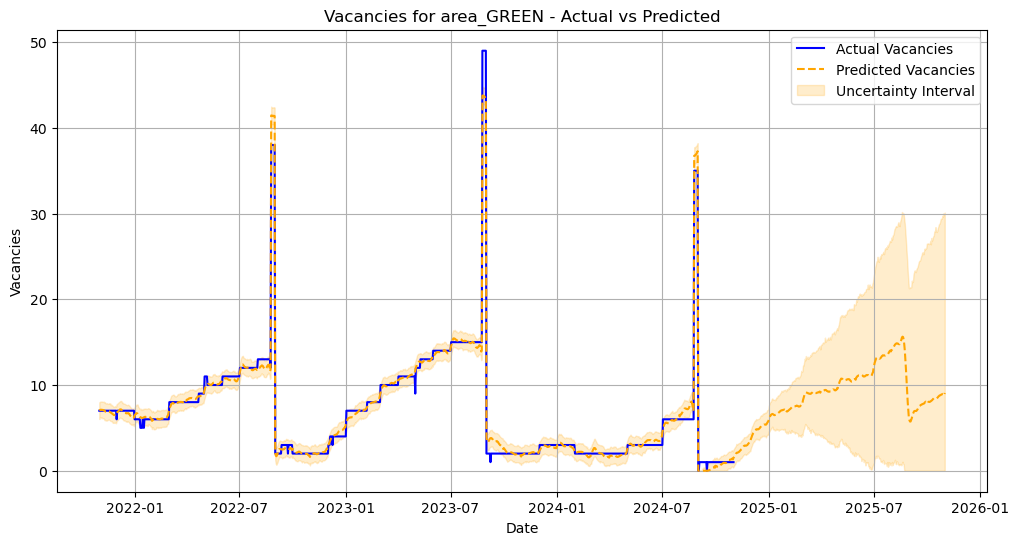

In [10]:
# Plot the forecast with actual values
plt.figure(figsize=(12, 6))
plt.plot(df_green['ds'], 
         df_green['y'],
         label="Actual Vacancies", 
         color='blue'
        )
plt.plot(forecast['ds'], 
         forecast['yhat'],
         label="Predicted Vacancies", 
         color='orange',
         linestyle='--'
        )
plt.fill_between(forecast['ds'], 
                 forecast['yhat_lower'], 
                 forecast['yhat_upper'],
                 color='orange', 
                 alpha=0.2, 
                 label="Uncertainty Interval"
                )
plt.title(f"Vacancies for {area} - Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Vacancies")
plt.legend()
plt.grid(True)
plt.savefig('../plots/before-tuning/forecasted_gc-before.png', dpi=300, bbox_inches='tight')
plt.show()

### 2. Cross Validation

In [11]:
# Perform cross-validation
# - 'initial' - the training period, here 730 days = 2 years
# - 'period' - the spacing between validation sets, here 180 days = 0.5 year
# - 'horizon' - the forecast horizon, here 365 days = 1 year
cv = cross_validation(model,
                      initial='730 days',
                      period='180 days',
                      horizon='365 days'
                     )
# Calculate performance metrics (MAE, MSE, RMSE)
# Evaluate errors
mae = mean_absolute_error(cv['y'], cv['yhat'])
mse = mean_squared_error(cv['y'], cv['yhat'])
rmse = np.sqrt(mse)

# Print metrics
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")

  0%|          | 0/1 [00:00<?, ?it/s]

21:05:27 - cmdstanpy - INFO - Chain [1] start processing
21:05:27 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 3.13
Mean Squared Error: 12.22
Root Mean Squared Error: 3.50


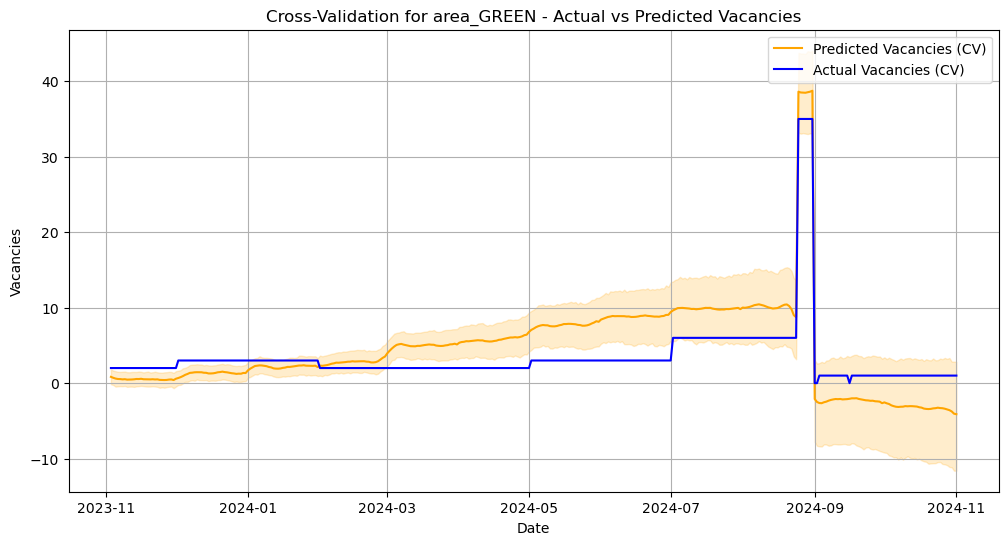

In [ ]:
# Plot cross validation results:
plt.figure(figsize=(12, 6))
plt.plot(cv['ds'], 
         cv['yhat'],
         label="Predicted Vacancies (CV)", 
         color='orange'
        )
plt.plot(cv['ds'], 
         cv['y'], 
         label="Actual Vacancies (CV)",
         color='blue'
        )
plt.fill_between(cv['ds'], 
                 cv['yhat_lower'], 
                 cv['yhat_upper'], 
                 color='orange', 
                 alpha=0.2
                )
plt.title(f"Cross-Validation for {area} - Actual vs Predicted Vacancies")
plt.xlabel("Date")
plt.ylabel("Vacancies")
plt.legend()
plt.grid(True)
plt.show()

### 3. Hyperparameter Tuning

In [13]:
from itertools import product

# Define a grid of hyperparameters
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1],
    'seasonality_prior_scale': [0.1, 1, 10],
    'yearly_seasonality': [10, 20, 30]
}

# Generate all combinations of hyperparameters
all_params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())] # generated with chatGPT 

# List to store results
param_results = []

# Iterate through each combination of parameters
for params in all_params:
    print(f"Testing parameters: {params}")
    
    # Initialize and fit the model with the current parameters
    model = Prophet(
        holidays=holidays, 
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        yearly_seasonality=params['yearly_seasonality'],
        seasonality_mode='additive'
    )
    model.add_regressor('end_of_month')
    model.fit(df_green)
    
    # Perform cross-validation
    cv_hp = cross_validation(
        model, 
        initial='730 days', 
        period='180 days', 
        horizon='365 days'
    )
    
    # Compute metrics
    metrics = performance_metrics(cv_hp)
    param_results.append((params, metrics['rmse'].mean()))

# Find the best parameters based on RMSE
best_params = min(param_results, key=lambda x: x[1])
print(f"Best parameters: {best_params[0]} with RMSE: {best_params[1]:.2f}")

Testing parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'yearly_seasonality': 10}


21:05:28 - cmdstanpy - INFO - Chain [1] start processing
21:05:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:05:29 - cmdstanpy - INFO - Chain [1] start processing
21:05:29 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'yearly_seasonality': 20}


21:05:29 - cmdstanpy - INFO - Chain [1] start processing
21:05:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:05:30 - cmdstanpy - INFO - Chain [1] start processing
21:05:30 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'yearly_seasonality': 30}


21:05:31 - cmdstanpy - INFO - Chain [1] start processing
21:05:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:05:31 - cmdstanpy - INFO - Chain [1] start processing
21:05:31 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1, 'yearly_seasonality': 10}


21:05:32 - cmdstanpy - INFO - Chain [1] start processing
21:05:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:05:32 - cmdstanpy - INFO - Chain [1] start processing
21:05:32 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1, 'yearly_seasonality': 20}


21:05:33 - cmdstanpy - INFO - Chain [1] start processing
21:05:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:05:33 - cmdstanpy - INFO - Chain [1] start processing
21:05:34 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1, 'yearly_seasonality': 30}


21:05:34 - cmdstanpy - INFO - Chain [1] start processing
21:05:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:05:35 - cmdstanpy - INFO - Chain [1] start processing
21:05:35 - cmdstanpy - INFO - Chain [1] done processing
21:05:36 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10, 'yearly_seasonality': 10}


21:05:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:05:36 - cmdstanpy - INFO - Chain [1] start processing
21:05:36 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10, 'yearly_seasonality': 20}


21:05:37 - cmdstanpy - INFO - Chain [1] start processing
21:05:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:05:37 - cmdstanpy - INFO - Chain [1] start processing
21:05:37 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10, 'yearly_seasonality': 30}


21:05:38 - cmdstanpy - INFO - Chain [1] start processing
21:05:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:05:38 - cmdstanpy - INFO - Chain [1] start processing
21:05:38 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'yearly_seasonality': 10}


21:05:39 - cmdstanpy - INFO - Chain [1] start processing
21:05:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:05:40 - cmdstanpy - INFO - Chain [1] start processing
21:05:40 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'yearly_seasonality': 20}


21:05:40 - cmdstanpy - INFO - Chain [1] start processing
21:05:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:05:41 - cmdstanpy - INFO - Chain [1] start processing
21:05:41 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'yearly_seasonality': 30}


21:05:42 - cmdstanpy - INFO - Chain [1] start processing
21:05:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:05:42 - cmdstanpy - INFO - Chain [1] start processing
21:05:42 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1, 'yearly_seasonality': 10}


21:05:43 - cmdstanpy - INFO - Chain [1] start processing
21:05:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:05:44 - cmdstanpy - INFO - Chain [1] start processing
21:05:44 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1, 'yearly_seasonality': 20}


21:05:44 - cmdstanpy - INFO - Chain [1] start processing
21:05:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:05:45 - cmdstanpy - INFO - Chain [1] start processing
21:05:45 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1, 'yearly_seasonality': 30}


21:05:46 - cmdstanpy - INFO - Chain [1] start processing
21:05:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:05:46 - cmdstanpy - INFO - Chain [1] start processing
21:05:47 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10, 'yearly_seasonality': 10}


21:05:47 - cmdstanpy - INFO - Chain [1] start processing
21:05:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:05:48 - cmdstanpy - INFO - Chain [1] start processing
21:05:48 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10, 'yearly_seasonality': 20}


21:05:49 - cmdstanpy - INFO - Chain [1] start processing
21:05:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:05:49 - cmdstanpy - INFO - Chain [1] start processing
21:05:49 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10, 'yearly_seasonality': 30}


21:05:50 - cmdstanpy - INFO - Chain [1] start processing
21:05:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:05:50 - cmdstanpy - INFO - Chain [1] start processing
21:05:51 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'yearly_seasonality': 10}


21:05:51 - cmdstanpy - INFO - Chain [1] start processing
21:05:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:05:52 - cmdstanpy - INFO - Chain [1] start processing
21:05:52 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'yearly_seasonality': 20}


21:05:53 - cmdstanpy - INFO - Chain [1] start processing
21:05:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:05:54 - cmdstanpy - INFO - Chain [1] start processing
21:05:55 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'yearly_seasonality': 30}


21:05:56 - cmdstanpy - INFO - Chain [1] start processing
21:05:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:05:57 - cmdstanpy - INFO - Chain [1] start processing
21:05:57 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1, 'yearly_seasonality': 10}


21:05:58 - cmdstanpy - INFO - Chain [1] start processing
21:05:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:05:59 - cmdstanpy - INFO - Chain [1] start processing
21:05:59 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1, 'yearly_seasonality': 20}


21:06:00 - cmdstanpy - INFO - Chain [1] start processing
21:06:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:06:01 - cmdstanpy - INFO - Chain [1] start processing
21:06:02 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1, 'yearly_seasonality': 30}


21:06:02 - cmdstanpy - INFO - Chain [1] start processing
21:06:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:06:04 - cmdstanpy - INFO - Chain [1] start processing
21:06:04 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10, 'yearly_seasonality': 10}


21:06:05 - cmdstanpy - INFO - Chain [1] start processing
21:06:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:06:06 - cmdstanpy - INFO - Chain [1] start processing
21:06:06 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10, 'yearly_seasonality': 20}


21:06:07 - cmdstanpy - INFO - Chain [1] start processing
21:06:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:06:08 - cmdstanpy - INFO - Chain [1] start processing
21:06:08 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10, 'yearly_seasonality': 30}


21:06:09 - cmdstanpy - INFO - Chain [1] start processing
21:06:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:06:11 - cmdstanpy - INFO - Chain [1] start processing
21:06:11 - cmdstanpy - INFO - Chain [1] done processing


Best parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'yearly_seasonality': 10} with RMSE: 3.42


### Final evaluation with best parameters

In [14]:
# Train the model with the best parameters
best_model = Prophet(
    holidays=holidays,
    changepoint_prior_scale=best_params[0]['changepoint_prior_scale'],
    seasonality_prior_scale=best_params[0]['seasonality_prior_scale'],
    yearly_seasonality=best_params[0]['yearly_seasonality'],
    seasonality_mode='additive'
)
best_model.add_regressor('end_of_month')
best_model.fit(df_green)

# Predict and visualize using the best model
future = best_model.make_future_dataframe(periods=365)
future['end_of_month'] = future['ds'].dt.is_month_end.astype(int)
forecast = best_model.predict(future)

# Clip the predicted values to ensure no negative values
forecast['yhat'] = forecast['yhat'].clip(lower=0)
forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower=0)
forecast['yhat_upper'] = forecast['yhat_upper'].clip(lower=0)

21:06:12 - cmdstanpy - INFO - Chain [1] start processing
21:06:13 - cmdstanpy - INFO - Chain [1] done processing


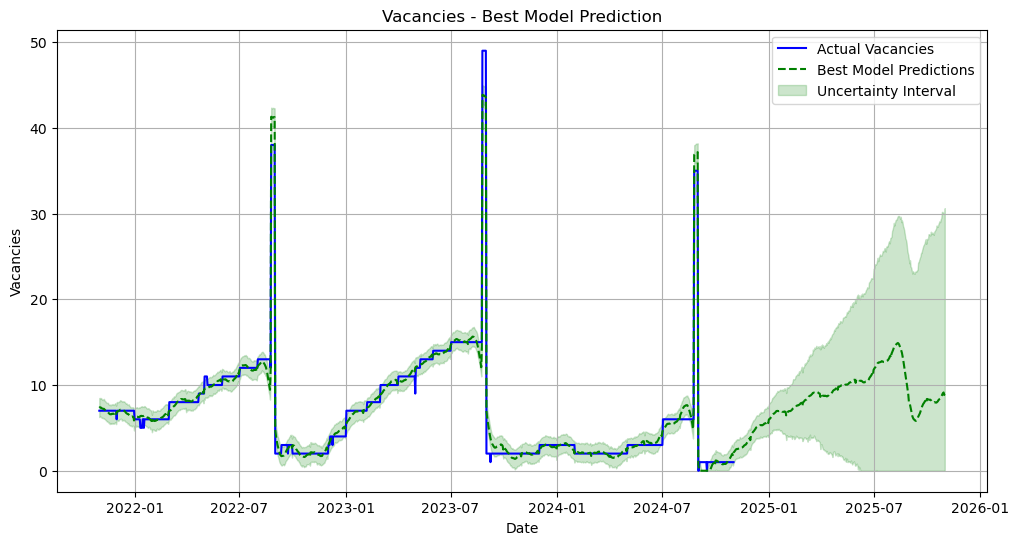

In [15]:
# Plot final forecast
plt.figure(figsize=(12, 6))
plt.plot(df_green['ds'], 
         df_green['y'], 
         label="Actual Vacancies",
         color='blue'
        )
plt.plot(forecast['ds'], 
         forecast['yhat'],
         label="Best Model Predictions",
         color='green',
         linestyle='--'
        )
plt.fill_between(
    forecast['ds'], 
    forecast['yhat_lower'], 
    forecast['yhat_upper'], 
    color='green', alpha=0.2, label="Uncertainty Interval"
)
plt.title("Vacancies - Best Model Prediction")
plt.xlabel("Date")
plt.ylabel("Vacancies")
plt.legend()
plt.grid(True)
plt.savefig('../plots/after-tuning/forecasted_gc-after.png', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
forecast.to_csv('../data/predictions/forecast_green.csv', index = False)
df_green.to_csv('../data/predictions/df_green.csv', index = False)